In [1]:
import jax.numpy as jnp
import jax
import numpy as np

from jax import config

config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
jax.default_backend()

'gpu'

In [3]:
np.random.seed(0)

In [4]:
def generate_gaussian_feature_matrix(n, k, tr):
    return (1 / np.sqrt(tr)) * jnp.asarray(np.random.randn(k, n))

In [5]:
def ReLU(z):
    return jnp.maximum(z,0)

def tanh(z):
    return jnp.tanh(z)

def sigmoid(z):
    return 1 / (1 + jnp.exp(-z))

def ReLU_prime(z):
    return jnp.where(z > 0, 1, 0)

def tanh_prime(z):
    return 1 - jnp.tanh(z)**2

def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [6]:
def data_generator(xi, gamma, m, n, theta, delta):
    gamma1, gamma2 = gamma
    theta1, theta2 = theta
    A1 = jnp.asarray(np.random.randn(m // 2, n))
    A2 = jnp.asarray(np.random.randn(m // 2, n))
    X1 = A1 @ (jnp.eye(n) + gamma1 @ ((jnp.sqrt(theta1 + 1) - 1) * gamma1.T))
    X2 = A2 @ (jnp.eye(n) + gamma2 @ ((jnp.sqrt(theta2 + 1) - 1) * gamma2.T))
    X = jnp.concatenate([X1, X2], axis=0)
    epsilon = jnp.asarray(np.random.randn(m, 1))
    y = ReLU(X @ xi) + delta * epsilon
    return X, y

In [7]:
def loss_calc(w, y, RF, lambd):
    return (1 / 2) * jnp.mean((y-RF.T @ w)**2) + (lambd / 2) * (jnp.linalg.norm(w) ** 2)

In [8]:
def least_square_estimator(y, RF, lambd):
    k, m = RF.shape
    w = jnp.linalg.solve(RF @ RF.T + lambd * m * jnp.eye(k), RF @ y)
    return w

In [9]:
n = 1000
m = 1000
lambd = 1e-4
delta = 0
NB_TRIALS = 20

In [10]:
from scipy.linalg import qr


def generate_data_structure(n, beta, alpha, align = 0, rho=0.5, d=1):
    theta_multiplier = np.power(n, beta * (1 - alpha))
    theta1 = np.zeros((n, 1))
    theta1[:d] = theta_multiplier #* np.random.rand(d, 1)
    theta1 = np.sort(theta1, axis=0)

    theta2 = np.zeros((n, 1))
    theta2[:d] = theta_multiplier #* np.random.rand(d, 1)
    theta2 = np.sort(theta2, axis=0)

    theta2 = theta2 * (np.sum(theta1) / np.sum(theta2))

    tr = n + np.sum(theta1)
    b = np.sqrt(n / tr)

    gamma1, _ = qr(np.random.randn(n, n))
    gamma2, _ = qr(np.random.randn(n, n))

    gamma2 = align * gamma1 + np.sqrt(1 - align**2) * gamma2

    Sigma1 = jnp.eye(n) + gamma1 @ (theta1 * gamma1.T)
    Sigma2 = jnp.eye(n) + gamma2 @ (theta2 * gamma2.T)

    Sigma = rho * Sigma1 + (1-rho)* Sigma2

    xi = jnp.asarray(np.random.randn(n, 1))
    xi = xi / (np.sqrt(jnp.linalg.norm(Sigma, ord=2)) * jnp.linalg.norm(xi))

    gamma = (gamma1, gamma2)
    theta = (theta1, theta2)

    return xi, gamma, tr, theta, b

In [11]:
from numpy.polynomial.hermite_e import hermeval

def Hermite(i, x):
    return jnp.asarray(hermeval(np.asarray(x), [0] * i + [1]))

def generate_Hermite_expansion(h, hs, b):
    act_func = lambda x: jnp.asarray(hermeval(np.asarray(x)/b, np.asarray(h))) + hs * jnp.asarray(np.random.randn(*x.shape))
    return act_func

In [12]:
from scipy.special import roots_hermitenorm

nodes, weights = roots_hermitenorm(100)
nodes = jnp.asarray(nodes)
weights = jnp.asarray(weights)

def calculate_expectation(func):
    # Expectation calculation with Gauss-Hermite quadrature
    return jnp.dot(weights, func(nodes)) / np.sqrt(2 * np.pi)

def calculate_h(activation, b):
    h = np.zeros(11)
    hs = np.zeros(11)
    h_var = calculate_expectation(lambda z: activation(b * z) ** 2)
    factorial = 1
    for i in range(11):
        h[i] = calculate_expectation(lambda z: Hermite(i, z) * activation(b * z))
        h_var = h_var - (1 / factorial) * (h[i] ** 2)
        h[i] = h[i] / factorial
        hs[i] = jnp.sqrt(h_var)
        factorial = factorial * (i + 1)
    return h, hs

In [13]:
import gc,sys

def clear_caches():
    for module_name, module in sys.modules.items():
        if module_name.startswith("jax"):
            if module_name not in ["jax.interpreters.partial_eval"]:
                for obj_name in dir(module):
                    obj = getattr(module, obj_name)
                    if hasattr(obj, "cache_clear"):
                        try:
                            obj.cache_clear()
                        except:
                            pass
    gc.collect()

In [14]:
r_vals = [0.1, 0.3, 0.4, 0.5, 0.7, 0.9, 1, 1.1, 1.5, 2, 3, 4, 5]

beta = 3 / 4 - 0.01
alpha = 1 / 2
eta = np.power(n, beta * alpha)
theta_multiplier = np.power(n, beta * (1 - alpha))
xi, gamma, tr, theta, b = generate_data_structure(n, beta, alpha, d=1)

dataF = data_generator(xi, gamma, m, n, theta, delta)
data = data_generator(xi, gamma, m, n, theta, delta)
data_new = data_generator(xi, gamma, 5*m, n, theta, delta)

l = 3
# Correspoding Hermite expansion
relu_h, relu_hs = calculate_h(ReLU, b)
tanh_h, tanh_hs = calculate_h(tanh, b)
sigmoid_h, sigmoid_hs = calculate_h(sigmoid, b)
relu_hermite = generate_Hermite_expansion(relu_h[:l+1], relu_hs[l], b)
tanh_hermite = generate_Hermite_expansion(tanh_h[:l+1], tanh_hs[l], b)
sigmoid_hermite = generate_Hermite_expansion(sigmoid_h[:l+1], sigmoid_hs[l], b)

relu_l_feature = np.zeros((len(r_vals), NB_TRIALS))
relu_gl_feature = np.zeros((len(r_vals), NB_TRIALS))
relu_l_hermite = np.zeros((len(r_vals), NB_TRIALS))
relu_gl_hermite = np.zeros((len(r_vals), NB_TRIALS))

tanh_l_feature = np.zeros((len(r_vals), NB_TRIALS))
tanh_gl_feature = np.zeros((len(r_vals), NB_TRIALS))
tanh_l_hermite = np.zeros((len(r_vals), NB_TRIALS))
tanh_gl_hermite = np.zeros((len(r_vals), NB_TRIALS))

sigmoid_l_feature = np.zeros((len(r_vals), NB_TRIALS))
sigmoid_gl_feature = np.zeros((len(r_vals), NB_TRIALS))
sigmoid_l_hermite = np.zeros((len(r_vals), NB_TRIALS))
sigmoid_gl_hermite = np.zeros((len(r_vals), NB_TRIALS))


def NN(w, F, dataF, data, data_new, activationF, activationF_derivative, activation, eta, lambd=lambd):
    k, n = F.shape
    X_tilde, y_tilde = dataF
    m_tilde = X_tilde.shape[0]
    FX_tilde = F @ X_tilde.T

    G = (1 / m_tilde) * ( (1/np.sqrt(k)) * (w @ (y_tilde.T - (1/np.sqrt(k)) * w.T @ activationF(FX_tilde))) * activationF_derivative(FX_tilde)) @ X_tilde
    F_hat = F + eta * G

    X, y = data
    X_new, y_new = data_new

    features = activation(F_hat @ X.T) / np.sqrt(k)
    features_new = activation(F_hat @ X_new.T) / np.sqrt(k)

    w_hat = least_square_estimator(y, features, lambd)
    loss_ = loss_calc(w_hat, y, features, lambd)
    gloss_ = loss_calc(w_hat, y_new, features_new, 0)

    return (loss_.item(), gloss_.item())

for e in tqdm(range(NB_TRIALS)):
    for r_i, r in enumerate(tqdm(r_vals)):
        k = int(m * r)
        F = generate_gaussian_feature_matrix(n, k, tr)
        w = jnp.asarray(np.random.randn(k, 1)) / np.sqrt(k)

        (
            relu_l_feature[r_i, e],
            relu_gl_feature[r_i, e],
        ) = NN(
            w,
            F,
            dataF,
            data,
            data_new,
            ReLU,
            ReLU_prime,
            ReLU,
            eta,
            lambd=lambd
        )

        (
            tanh_l_feature[r_i, e],
            tanh_gl_feature[r_i, e],
        ) = NN(
            w,
            F,
            dataF,
            data,
            data_new,
            tanh,
            tanh_prime,
            tanh,
            eta,
            lambd=lambd
        )

        (
            sigmoid_l_feature[r_i, e],
            sigmoid_gl_feature[r_i, e],
        ) = NN(
            w,
            F,
            dataF,
            data,
            data_new,
            sigmoid,
            sigmoid_prime,
            sigmoid,
            eta,
            lambd=lambd,
        )

        (
            relu_l_hermite[r_i, e],
            relu_gl_hermite[r_i, e],
        ) = NN(
            w,
            F,
            dataF,
            data,
            data_new,
            ReLU,
            ReLU_prime,
            relu_hermite,
            eta,
            lambd=lambd
        )

        (
            tanh_l_hermite[r_i, e],
            tanh_gl_hermite[r_i, e],
        ) = NN(
            w,
            F,
            dataF,
            data,
            data_new,
            tanh,
            tanh_prime,
            tanh_hermite,
            eta,
            lambd=lambd
        )

        (
            sigmoid_l_hermite[r_i, e],
            sigmoid_gl_hermite[r_i, e],
        ) = NN(
            w,
            F,
            dataF,
            data,
            data_new,
            sigmoid,
            sigmoid_prime,
            sigmoid_hermite,
            eta,
            lambd=lambd,
        )


        clear_caches()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [17]:
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)

plt.style.use(["science", "bright"])
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.serif": ["Times"],
        "font.size": 10,
        "figure.dpi": "600",
    }
)

colors = ["#0072B2", "#E69F00", "#CC79A7"]

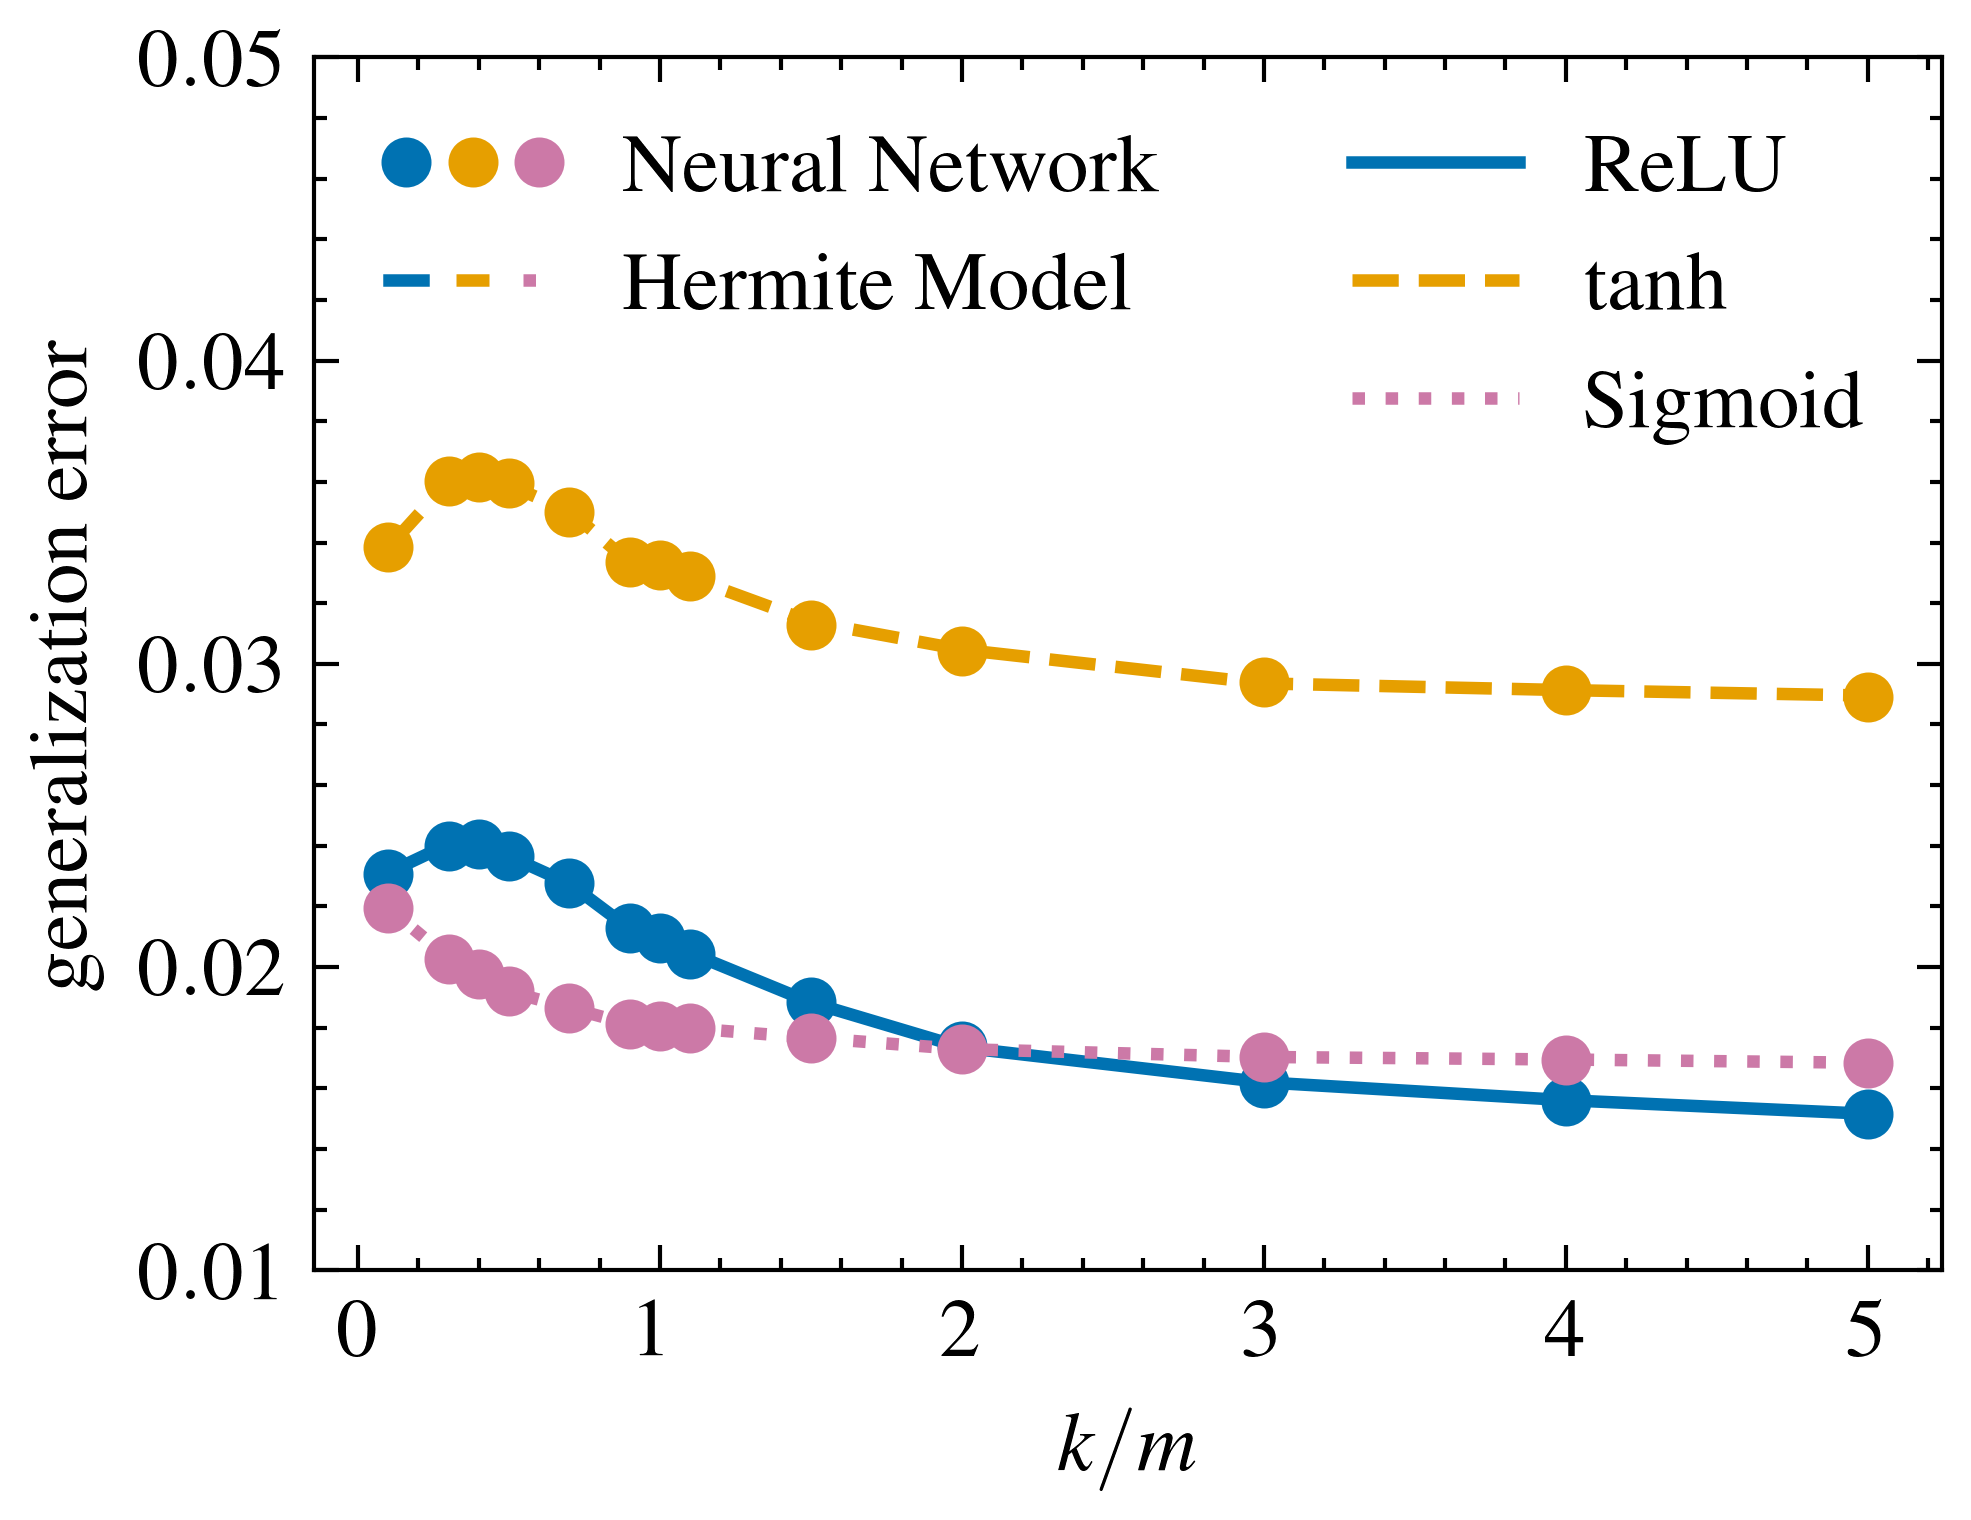

In [18]:
from matplotlib.legend_handler import HandlerTuple

plt.figure()
(relu_feature_gen,) = plt.plot(
    r_vals,
    np.mean(relu_gl_feature, axis=1),
    color=colors[0],
    linestyle="None",
    marker="o",
    markersize=5,
)

(relu_hermite_gen,) = plt.plot(
    r_vals,
    np.mean(relu_gl_hermite, axis=1),
    color=colors[0],
    linestyle="solid",
    linewidth=1.5,
    label="ReLU",
)

(tanh_feature_gen,) = plt.plot(
    r_vals,
    np.mean(tanh_gl_feature, axis=1),
    color=colors[1],
    linestyle="None",
    marker="o",
    markersize=5,
)
(tanh_hermite_gen,) = plt.plot(
    r_vals,
    np.mean(tanh_gl_hermite, axis=1),
    color=colors[1],
    linestyle="dashed",
    linewidth=1.5,
    label="tanh",
)

(sigmoid_feature_gen,) = plt.plot(
    r_vals,
    np.mean(sigmoid_gl_feature, axis=1),
    color=colors[2],
    linestyle="None",
    marker="o",
    markersize=5,
)

(sigmoid_hermite_gen,) = plt.plot(
    r_vals,
    np.mean(sigmoid_gl_hermite, axis=1),
    color=colors[2],
    linestyle="dotted",
    linewidth=1.5,
    label="sigmoid",
)

plt.xlabel(r"$k/m$")
plt.ylabel(r"generalization error")
plt.ylim(0.01, 0.05)
#plt.xlim(0.3, 5)

legend1 = plt.legend(
    (relu_hermite_gen, tanh_hermite_gen, sigmoid_hermite_gen),
    ["ReLU", "tanh", "Sigmoid"],
    loc=1,
    handler_map={tuple: HandlerTuple(ndivide=None)},
)
legend2 = plt.legend(
    [
        (relu_feature_gen, tanh_feature_gen, sigmoid_feature_gen),
        (relu_hermite_gen, tanh_hermite_gen, sigmoid_hermite_gen),
    ],
    [
        "Neural Network",
        "Hermite Model",
    ],
    loc=2,
    handler_map={tuple: HandlerTuple(ndivide=None)},
)
plt.gca().add_artist(legend1)

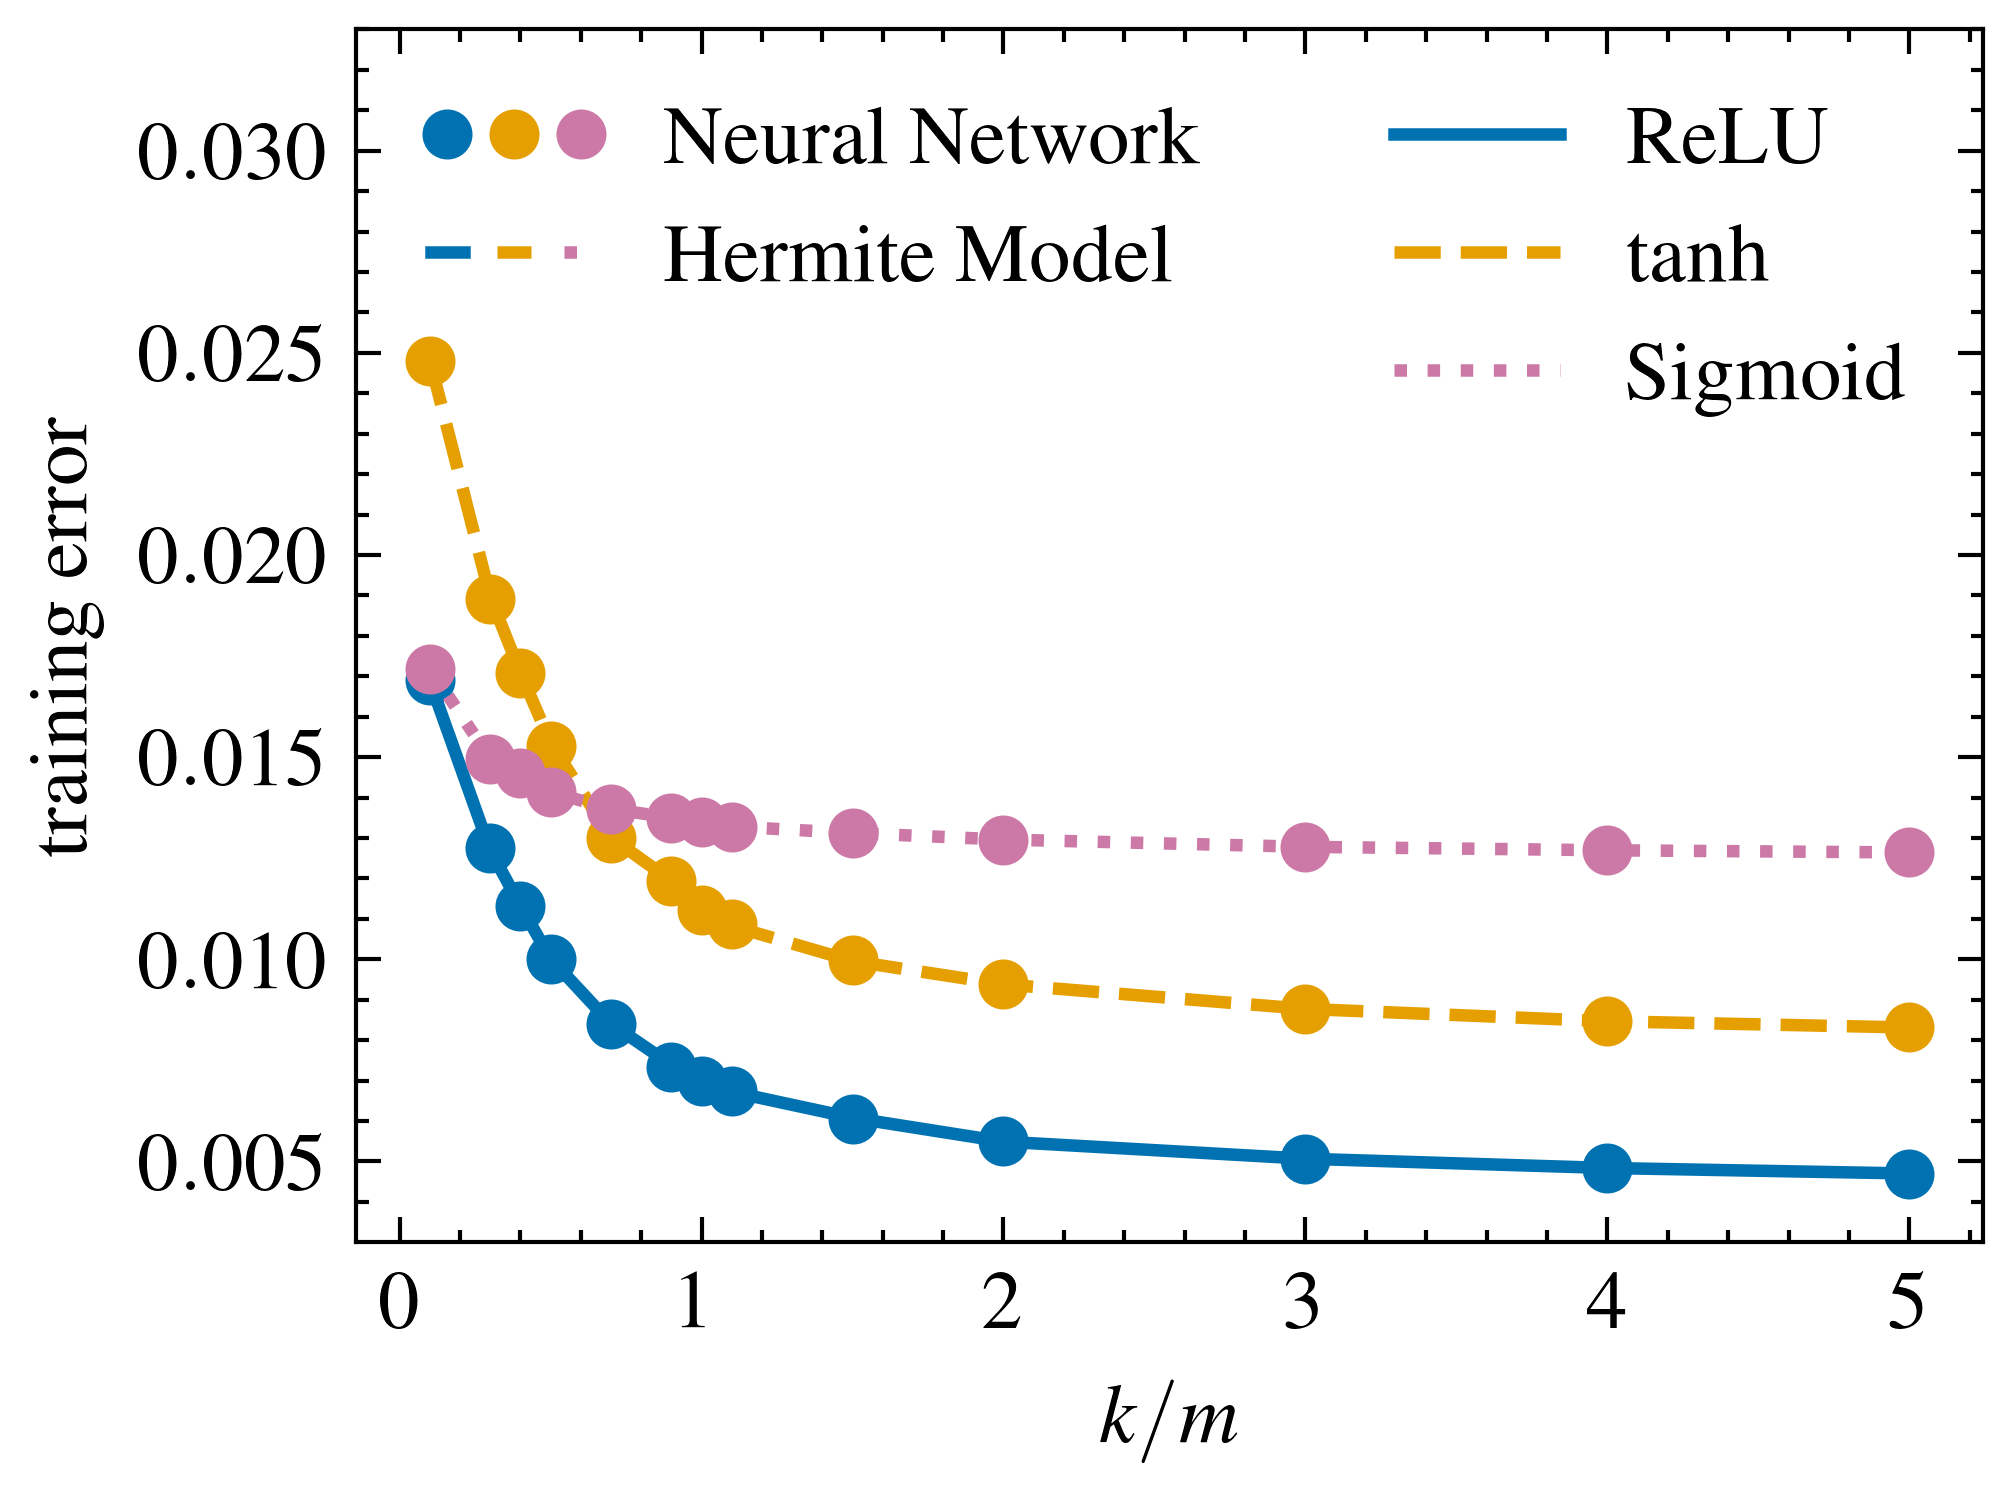

In [21]:
from matplotlib.legend_handler import HandlerTuple

plt.figure()
(relu_feature_gen,) = plt.plot(
    r_vals,
    np.mean(relu_l_feature, axis=1),
    color=colors[0],
    linestyle="None",
    marker="o",
    markersize=5,
)

(relu_hermite_gen,) = plt.plot(
    r_vals,
    np.mean(relu_l_hermite, axis=1),
    color=colors[0],
    linestyle="solid",
    linewidth=1.5,
    label="ReLU",
)

(tanh_feature_gen,) = plt.plot(
    r_vals,
    np.mean(tanh_l_feature, axis=1),
    color=colors[1],
    linestyle="None",
    marker="o",
    markersize=5,
)
(tanh_hermite_gen,) = plt.plot(
    r_vals,
    np.mean(tanh_l_hermite, axis=1),
    color=colors[1],
    linestyle="dashed",
    linewidth=1.5,
    label="tanh",
)

(sigmoid_feature_gen,) = plt.plot(
    r_vals,
    np.mean(sigmoid_l_feature, axis=1),
    color=colors[2],
    linestyle="None",
    marker="o",
    markersize=5,
)

(sigmoid_hermite_gen,) = plt.plot(
    r_vals,
    np.mean(sigmoid_l_hermite, axis=1),
    color=colors[2],
    linestyle="dotted",
    linewidth=1.5,
    label="sigmoid",
)

plt.xlabel(r"$k/m$")
plt.ylabel(r"training error")
plt.ylim(0.003, 0.033)
#plt.xlim(0.3, 5)

legend1 = plt.legend(
    (relu_hermite_gen, tanh_hermite_gen, sigmoid_hermite_gen),
    ["ReLU", "tanh", "Sigmoid"],
    loc=1,
    handler_map={tuple: HandlerTuple(ndivide=None)},
)
legend2 = plt.legend(
    [
        (relu_feature_gen, tanh_feature_gen, sigmoid_feature_gen),
        (relu_hermite_gen, tanh_hermite_gen, sigmoid_hermite_gen),
    ],
    [
        "Neural Network",
        "Hermite Model",
    ],
    loc=2,
    handler_map={tuple: HandlerTuple(ndivide=None)},
)
plt.gca().add_artist(legend1)